In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar datos (asumiendo que ya habéis unido las features con las labels si venían separadas)
df = pd.read_csv("tanzania_water_pump_org.csv")


In [20]:
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,03/05/2013,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,07/05/2011,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,11/04/2011,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,08/03/2011,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [21]:

# Separar X (variables) e y (etiqueta/target)
X = df.drop("status_group", axis=1) # Suponiendo que 'status_group' es la clase
y = df["status_group"]

# LA PARTICIÓN CLAVE
# test_size=0.2 deja el 20% para el test final.
# random_state=42 (u otro número) asegura que siempre salga la misma división (reproducibilidad).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Guardar el Test en un archivo "fuerte" y no tocarlo hasta el final
# Guardar el Train para trabajar con él


In [22]:
# Guardar los conjuntos de entrenamiento
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# Guardar los conjuntos de prueba (el "cofre" que no se toca)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [23]:
import pandas as pd
import numpy as np
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3607,454,50.0,27/02/2013,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
50870,510,0.0,17/03/2011,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
20413,14146,0.0,10/07/2011,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
52806,47410,0.0,12/04/2011,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
50091,1288,300.0,05/04/2011,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [24]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_columns)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


# ANTONIO VA A REMPLAZARLO

In [ ]:
# aplicar esta factorización a la lista de categorical_columns
for column in categorical_columns:
    X_train[[column]] = df[[column]].apply(lambda x: pd.factorize(x)[0])
    df[column].replace(-1, np.nan, inplace=True)

In [12]:
from yellowbrick.contrib.missing import MissingValuesDispersion

# visualizador de la columna installer
visualizer = MissingValuesDispersion(features=X_train.columns)
visualizer.fit(X_train)
visualizer.show()

ModuleNotFoundError: No module named 'yellowbrick'

In [25]:
threshold = len(X_train) * 0.3

X_train = X_train.dropna(thresh=threshold, axis=1)

print(X_train.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


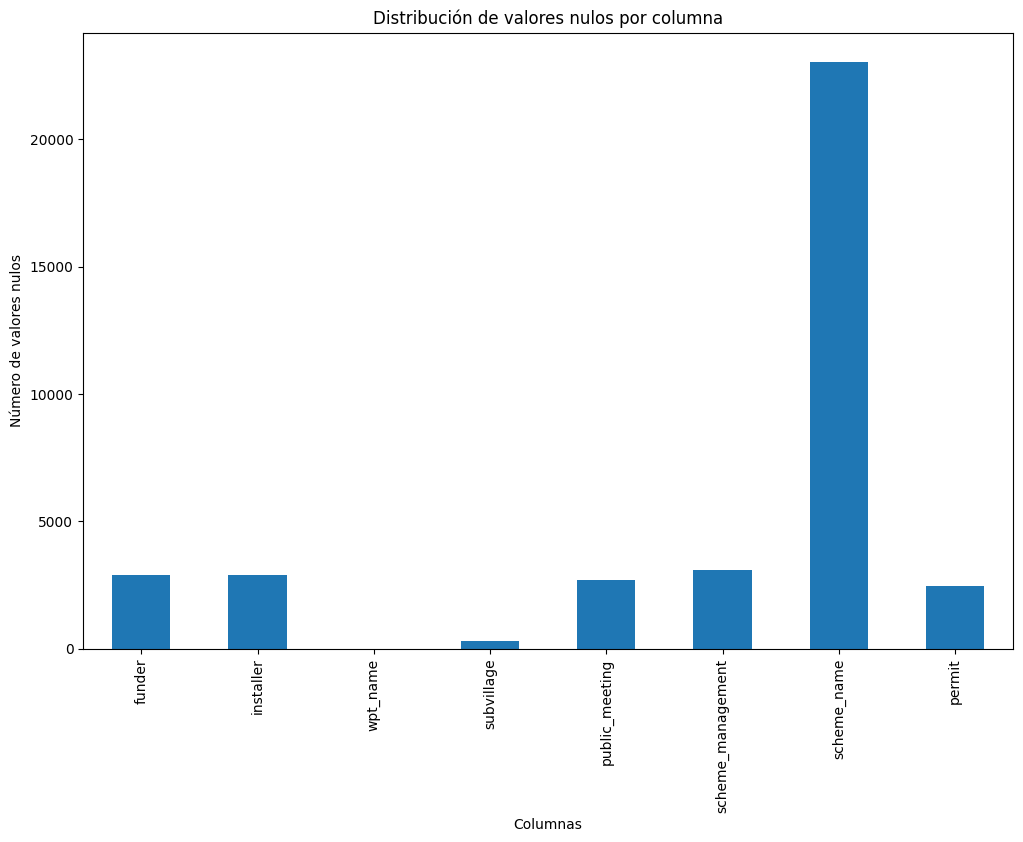

In [26]:
import matplotlib.pyplot as plt

# Contar los valores nulos en cada columna
missing_values = X_train.isnull().sum()

# Filtrar las columnas que tienen valores nulos
missing_values = missing_values[missing_values > 0]

# Crear un gráfico de barras para mostrar la distribución de valores nulos
plt.figure(figsize=(12, 8))
missing_values.plot(kind='bar')
plt.title('Distribución de valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Número de valores nulos')
plt.show()

In [27]:
from sklearn.impute import SimpleImputer
#imputar valores nulos con la media de cada columna y la moda

# Identificar columnas numéricas y categóricas
columnas_numericas = X_train.select_dtypes(include=['number']).columns
columnas_categoricas = X_train.select_dtypes(exclude=['number']).columns

# Imputar columnas numéricas con la media
imputador_numerico = SimpleImputer(strategy='mean')
X_train_numerico = pd.DataFrame(imputador_numerico.fit_transform(X_train[columnas_numericas]), columns=columnas_numericas)

# Imputar columnas categóricas con la moda
imputador_categorico = SimpleImputer(strategy='most_frequent')
X_train_categorico = pd.DataFrame(imputador_categorico.fit_transform(X_train[columnas_categoricas]), columns=columnas_categoricas)

# Combinar los datos imputados
X_train_imputado = pd.concat([X_train_numerico, X_train_categorico], axis=1)

# Asegurar que las columnas estén en el orden original
X_train_imputado = X_train_imputado[X_train.columns]

# Opcional: Verificar que no queden valores faltantes
print(X_train_imputado.isnull().sum())

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

In [28]:
X_train_imputado.to_csv('X_train_prep.csv', index=False)